## Dataset Content

The dataset was provided by the Mexican government (link). This dataset contains an enormous number of anonymized patient-related information including pre-conditions. The raw dataset consists of 21 unique features and 1,048,576 unique patients. In the Boolean features, 1 means "yes" and 2 means "no". values as 97 and 99 are missing data.

    sex: female or male
    age: of the patient.
    classification: covid_df test findings. Values 1-3 mean that the patient was diagnosed with covid_df in different
    degrees. 4 or higher means that the patient is not a carrier of covid_df or that the test is inconclusive.
    patient type: hospitalized or not hospitalized.
    pneumonia: whether the patient already have air sacs inflammation or not.
    pregnancy: whether the patient is pregnant or not.
    diabetes: whether the patient has diabetes or not.
    copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
    asthma: whether the patient has asthma or not.
    inmsupr: whether the patient is immunosuppressed or not.
    hypertension: whether the patient has hypertension or not.
    cardiovascular: whether the patient has heart or blood vessels related disease.
    renal chronic: whether the patient has chronic renal disease or not.
    other disease: whether the patient has other disease or not.
    obesity: whether the patient is obese or not.
    tobacco: whether the patient is a tobacco user.
    usmr: Indicates whether the patient treated medical units of the first, second or third level.
    medical unit: type of institution of the National Health System that provided the care.
    intubed: whether the patient was connected to the ventilator.
    icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
    death: indicates whether the patient died or recovered.


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.neural_network import MLPClassifier

In [6]:
covid_df = pd.read_csv("Covid Data.csv")

covid_df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


## Data Preprocessing

In [8]:
#only keep covid_df positive patient data
covid_df = covid_df.loc[(covid_df.CLASIFFICATION_FINAL < 4)]
#Cleaning the data to keep only the rows containing 1, 2
covid_df = covid_df[(covid_df.PNEUMONIA == 1) | (covid_df.PNEUMONIA == 2)] #uses bitwise OR
covid_df = covid_df[(covid_df.DIABETES == 1) | (covid_df.DIABETES == 2)]
covid_df = covid_df[(covid_df.COPD == 1) | (covid_df.COPD == 2)]
covid_df = covid_df[(covid_df.ASTHMA == 1) | (covid_df.ASTHMA == 2)]
covid_df = covid_df[(covid_df.INMSUPR == 1) | (covid_df.INMSUPR == 2)]
covid_df = covid_df[(covid_df.HIPERTENSION == 1) | (covid_df.HIPERTENSION == 2)]
covid_df = covid_df[(covid_df.OTHER_DISEASE == 1) | (covid_df.OTHER_DISEASE == 2)]
covid_df = covid_df[(covid_df.CARDIOVASCULAR == 1) | (covid_df.CARDIOVASCULAR == 2)]
covid_df = covid_df[(covid_df.OBESITY == 1) | (covid_df.OBESITY == 2)]
covid_df = covid_df[(covid_df.RENAL_CHRONIC == 1) | (covid_df.RENAL_CHRONIC == 2)]
covid_df = covid_df[(covid_df.TOBACCO == 1) | (covid_df.TOBACCO == 2)]
#if death date given, mark it as 1, else 0
covid_df.DATE_DIED = covid_df.DATE_DIED.apply(lambda x: 0 if x == "9999-99-99" else 1) #ruins data visualization
#if data missing, mark it as a 0
covid_df.INTUBED = covid_df.INTUBED.apply(lambda x: x if x == 1 else 0)                   
covid_df.ICU = covid_df.ICU.apply(lambda x: x if x == 1 else 0)

covid_df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,1,0,1,65,2,2,...,2,2,1,2,2,2,2,2,3,0
2,2,1,2,2,1,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,0
4,2,1,2,1,1,0,2,68,97,1,...,2,2,1,2,2,2,2,2,3,0
5,2,1,1,2,0,0,1,40,2,2,...,2,2,2,2,2,2,2,2,3,0
6,2,1,1,1,0,0,2,64,2,2,...,2,2,2,2,2,2,2,2,3,0


In [12]:
#create the at risk column
covid_df['AT_RISK'] = covid_df['DATE_DIED'] + covid_df['INTUBED'] + covid_df['ICU']
covid_df.AT_RISK = covid_df.AT_RISK.apply(lambda x: 1 if x > 0 else 0) 

#columns no longer useful bc: 
# all patients are now covid_df positive 
# the rest of the columns are repped by the at risk column now (death date dropped later)
covid_df.drop(columns = ['CLASIFFICATION_FINAL', 'INTUBED', 'ICU'], inplace=True)

covid_df.head()

KeyError: 'INTUBED'

In [13]:
print(covid_df.PREGNANT.value_counts())

#98 = female not pregnant, set to 2 for not pregnant
covid_df.PREGNANT = covid_df.PREGNANT.replace(98, 2)
#97 = men, set to 2 for not pregnant
covid_df.PREGNANT = covid_df.PREGNANT.replace(97, 2)

print(covid_df.PREGNANT.value_counts())

2    386134
1      2744
Name: PREGNANT, dtype: int64
2    386134
1      2744
Name: PREGNANT, dtype: int64


## Data Visualization

In [ ]:
#die date vars created 
covid_df["MONTH"] = covid_df.DATE_DIED.str.split("/", expand = True)[1]
covid_df["YEAR"] = covid_df.DATE_DIED.str.split("/", expand = True)[2]

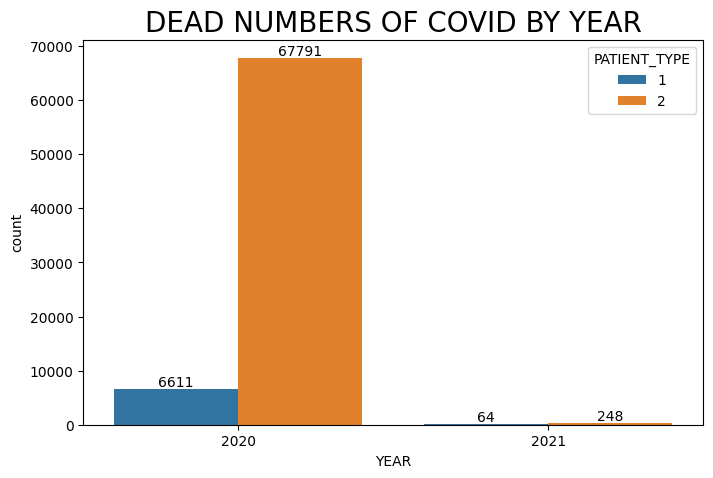

In [9]:
#count number of patients died each year by patient type (1=not hopitalized, 2=hospitalized)
plt.figure(figsize = (8,5))
ax = sns.countplot(x = "YEAR", hue = "PATIENT_TYPE", data = covid_df)
plt.title("DEAD NUMBERS OF COVID BY YEAR", fontsize = 20)
for bars in ax.containers:
    ax.bar_label(bars)

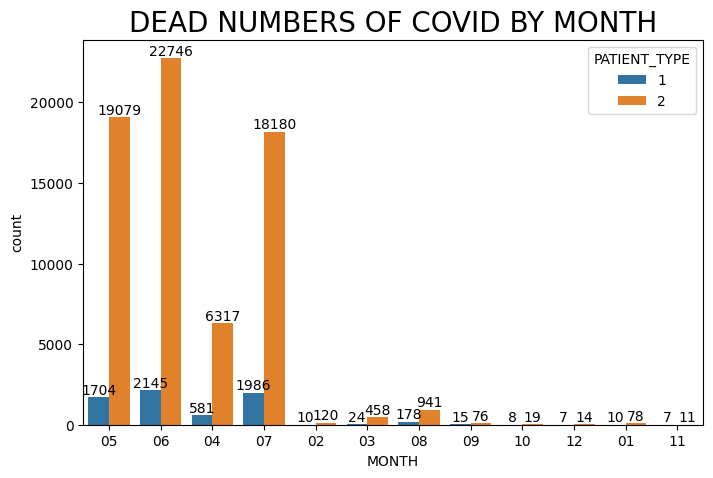

In [10]:
#months ppl most died in
plt.figure(figsize = (8,5))
ax = sns.countplot(x = "MONTH", hue = "PATIENT_TYPE", data = covid_df)
plt.title("DEAD NUMBERS OF COVID BY MONTH", fontsize = 20)
for bars in ax.containers:
    ax.bar_label(bars)

In [ ]:
#drop death info
covid_df.drop(["MONTH", "YEAR"], axis = 1, inplace = True)

## MLP Classifier

In [ ]:
#drop death info
covid_df.drop(["DATE_DIED"], axis = 1, inplace = True)

#drop targets from x and set them as y
X = covid_df.drop("AT_RISK", axis = 1)
Y = covid_df["AT_RISK"]

#split data into training and test
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size = 0.3, random_state = 0) #rand state so same rando shuffle

covid_df.head()

In [15]:
#create validation set
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2, random_state=0)

layers = [(100,50,30,10,5), (15,10,5,10,15), (20,20,20,20), (10)]
optimizers = ['adam', 'sgd']
mlp_accuracy = {}
mlp_best_result = 0

for (i, opt) in  enumerate(optimizers):
    mlp_accuracy[i] = np.zeros(len(layers))
    for (j, layer) in enumerate(layers):
        # create a Logistic Regression classifier instance and compute the prediction
        mlp_classifier = MLPClassifier(hidden_layer_sizes = layer,
                                          solver = opt,
                                          learning_rate ='adaptive',
                                          max_iter = 500)
        mlp_classifier.fit(x_train, y_train)
        y_pred = mlp_classifier.predict(x_val)

        # calculate accuracy and save best model
        mlp_accuracy[i][j] = accuracy_score(y_pred, y_val)
        if mlp_accuracy[i][j] > mlp_best_result:
            mlp_best_result = mlp_accuracy[i][j]
            mlp_best_model = mlp_classifier

params = mlp_best_model.get_params()
print('best result for: optimizer = %s, layer = %s, Accuracy = %f' % (params['solver'], params['hidden_layer_sizes'], mlp_best_result))

0.6625090230404558


In [20]:
# create a Logistic Regression classifier instance and compute the prediction
mlpClassifier = MLPClassifier(
        hidden_layer_sizes = (15,10,5,10,15),
        solver = 'adam',
        learning_rate ='adaptive',
        max_iter = 500
    )
mlpClassifier.fit(x_train, y_train)
yPred = mlpClassifier.predict(x_test)
print(f"MLP test accuracy = {accuracy_score(yPred, y_test)}")

MLP test accuracy = 0.8918603853802373


## Xgboost Model

In [22]:
from xgboost import XGBClassifier
#init model
xgb = XGBClassifier(n_estimators = 200, 
                    learning_rate=0.1)
#train model
xgb.fit(x_train, y_train)
#pred with model
ypred = xgb.predict(x_test)

In [23]:
#compute forms of accuracy
accuracy_score(ypred, y_test)
roc_auc_score(ypred, y_test)
#display accuracies
print("XGB Model's Accuracy = " + str(accuracy_score(ypred, y_test)))
print("XGB Model's AUC score = " + str(roc_auc_score(ypred, y_test)))

XGB Model's Accuracy = 0.8927689775766303
XGB Model's AUC score = 0.7946055876698483


## Result Metrics

In [21]:
def get_Fmeasure(prediction, labels):

  # Compares the prediction of each object to its label
  true_positive = np.sum((prediction + labels) == 2)
  false_positive = np.sum((labels - prediction) == -1)
  false_negative = np.sum((prediction - labels) == -1)
  positive = np.count_nonzero(labels == 1)
  negative = len(labels)-positive

  # Calculate F-measure
  accuracy = 100*np.sum(prediction == labels)/len(labels)
  recall = true_positive / (true_positive + false_negative)
  precision = true_positive / (true_positive + false_positive)
  eval = 2*(precision * recall) / (precision + recall)
  return eval

get_Fmeasure(yPred, y_test)

0.6655355249204666

## Feature Importance

In [56]:
dfFeatureImportances = pd.DataFrame(list(X), xgb.feature_importances_)
dfFeatureImportances.columns = ["Feature_Names"]
dfFeatureImportances["Importances"] = dfFeatureImportances.index
dfFeatureImportances = dfFeatureImportances.sort_values(by = "Importances", ascending = False)
dfFeatureImportances.index = np.arange(0,len(dfFeatureImportances))

dfFeatureImportances

,Feature_Names,Importances
0,PNEUMONIA,0.615886
1,PATIENT_TYPE,0.101850
2,AGE,0.039277
3,OBESITY,0.036628
4,SEX,0.026029
5,TOBACCO,0.025497
6,MEDICAL_UNIT,0.023651
7,RENAL_CHRONIC,0.020751
8,COPD,0.017715
9,INMSUPR,0.016944
